# Using the OpenAQ API

The `openaq` api is an easy-to-use wrapper built around the [OpenAQ Api](https://docs.openaq.org/). Complete API documentation can be found on their website. 

There are no keys or rate limits (as of March 2017), so working with the API is straight forward. If building a website or app, you may want to just use the python wrapper and interact with the data in json format. However, the rest of this tutorial will assume you are interested in analyzing the data. To get more out of it, I recommend installing `seaborn` for manipulating the asthetics of plots, and working with data as DataFrames using `pandas`. For more information on these, check out the installation section of this documentation.

From this point forward, I assume you have at least a basic knowledge of python and matplotlib. This documentation was built using the following versions of all packages:

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings

warnings.simplefilter('ignore')

%matplotlib inline

# Set major seaborn asthetics
sns.set("notebook", style='ticks', font_scale=1.0)

# Increase the quality of inline plots
mpl.rcParams['figure.dpi']= 500

print ("pandas v{}".format(pd.__version__))
print ("matplotlib v{}".format(mpl.__version__))
print ("seaborn v{}".format(sns.__version__))
print ("openaq v{}".format(openaq.__version__))

pandas v0.21.0
matplotlib v2.1.0
seaborn v0.8.1
openaq v1.1.0


## OpenAQ API

The OpenAQ APi has only eight endpoints that we are interested in:

  * cities: provides a simple listing of cities within the platforms
  * countries: provides a simple listing of countries within the platform
  * fetches: providing data about individual fetch operations that are used to populate data in the platform
  * latest: provides the latest value of each available parameter for every location in the system
  * locations: provides a list of measurement locations and their meta data
  * measurements: provides data about individual measurements
  * parameters: provides a simple listing of parameters within the platform
  * sources: provides a list of data sources
  
For detailed documentation about each one in the context of this API wrapper, please check out the API documentation.

### Your First Request

Real quick, let's go ahead and initiate an instance of the `openaq.OpenAQ` class so we can begin looking at data:

In [2]:
api = openaq.OpenAQ()

### Cities

The cities API endpoint lists the cities available within the platform. Results can be subselected by country and paginated to retrieve all results in the database. Let's start by performing a basic query with an increased limit (so we can get all of them) and return it as a DataFrame:

In [3]:
resp = api.cities(df=True, limit=10000)

# display the first 10 rows
resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2020 entries, 0 to 2019
Data columns (total 4 columns):
city         2020 non-null object
count        2020 non-null int64
country      2020 non-null object
locations    2020 non-null int64
dtypes: int64(2), object(2)
memory usage: 63.2+ KB


So we retrieved 1400+ entries from the database. We can then take a look at them:

In [4]:
print (resp.head(10))

                                             city   count country  locations
0                                          unused     314      AD          1
1                              Escaldes-Engordany   13312      AD          2
2                                       Abu Dhabi     475      AE          1
3                                    Buenos Aires   14976      AR          4
4                                         Austria  121987      AT        174
5                 Amt der Tiroler Landesregierung  113161      AT         19
6            Umweltinstitut des Landes Vorarlberg   36108      AT          9
7    Amt der Ober�sterreichischen Landesregierung  154329      AT         16
8  Amt der Nieder�sterreichischen Landesregierung  322499      AT         39
9                Gemeinde Wien, MA22 Umweltschutz  130328      AT         21


Let's try to find out which ones are in India:

In [5]:
print (resp.query("country == 'IN'"))

                   city    count country  locations
841              Nagpur    72304      IN          5
842            Tirupati   159051      IN          4
843           Ahmedabad    57664      IN          2
844           Bengaluru   371507      IN          8
845           Moradabad    24572      IN          1
846   Rajamahendravaram    30562      IN          3
847             Lucknow   271760      IN          5
848              Kanpur   159648      IN          2
849              Jaipur   190303      IN          6
850           Amaravati    11390      IN          1
851           Ghaziabad    99046      IN          2
852               Delhi  1140039      IN         35
853    Mandi Gobindgarh    48579      IN          1
854           Panchkula   144904      IN          1
855          Barddhaman     2470      IN          3
856          Chandrapur   232167      IN          2
857              Mumbai   309415      IN          3
858         Navi Mumbai     7713      IN          1
859         

Great! For the rest of the tutorial, we are going to focus on Delhi, India. Why? Well..because there are over 500,000 data points and my personal research is primarily in India. We will also take a look at some $SO_2$ data from Hawai'i later on (another great research locale).

## Countries

Similar to the `cities` endpoint, the `countries` endpoint lists the countries available. The only parameters we have to play with are the limit and page number. If we want to grab them all, we can just up the limit to the maximum (10000).

In [7]:
res = api.countries(limit=10000, df=True)

print (res.head())

   cities code    count  locations       name
0       2   AD    13626          3    Andorra
1       1   AR    14976          4  Argentina
2      18   AU  3246949         99  Australia
3      16   AT  1521351        306    Austria
4       1   BH    13816          1    Bahrain


## Fetches

If you are interested in getting information pertaining to the individual data fetch operations, go ahead and use this endpoint. Most people won't need to use this. This API method does not allow the `df` parameter; if you would like it to be added, drop me a message.

Otherwise, here is how you can access the json-formatted data:

In [9]:
status, resp = api.fetches(limit=1)

# Print out the meta info
resp['meta']

{'found': 92493,
 'license': 'CC BY 4.0',
 'limit': 1,
 'name': 'openaq-api',
 'page': 1,
 'pages': 92493,
 'website': 'https://docs.openaq.org/'}

## Parameters

The `parameters` endpoint will provide a listing off all the parameters available:

In [10]:
res = api.parameters(df=True)

print (res)

                                         description    id   name  \
0                                       Black Carbon    bc     BC   
1                                    Carbon Monoxide    co     CO   
2                                   Nitrogen Dioxide   no2    NO2   
3                                              Ozone    o3     O3   
4  Particulate matter less than 10 micrometers in...  pm10   PM10   
5  Particulate matter less than 2.5 micrometers i...  pm25  PM2.5   
6                                     Sulfur Dioxide   so2    SO2   

  preferredUnit  
0         µg/m³  
1           ppm  
2           ppm  
3           ppm  
4         µg/m³  
5         µg/m³  
6           ppm  


## Sources

The `sources` endpoint will provide a list of the sources where the raw data came from.

In [11]:
res = api.sources(df=True)

# Print out the first one
res.ix[0]

active                                                       True
adapter                                                 arpalazio
city                                                          NaN
contacts                                        [info@openaq.org]
country                                                        IT
description             Air quality data from Lazio region, Italy
location                                                      NaN
name                                                    ARPALAZIO
organization                                                  NaN
region                                                      Lazio
resolution                                                    NaN
sourceURL                               http://www.arpalazio.net/
timezone                                                      NaN
url             http://www.arpalazio.net/main/aria/sci/annoinc...
Name: 0, dtype: object

## Locations

The `locations` endpoint will return the list of measurement locations and their meta data. We can do quite a bit of querying with this one:

Let's see what the data looks like:

In [12]:
res = api.locations(df=True)

res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
city                     100 non-null object
coordinates.latitude     100 non-null float64
coordinates.longitude    100 non-null float64
count                    100 non-null int64
country                  100 non-null object
firstUpdated             100 non-null datetime64[ns]
lastUpdated              100 non-null datetime64[ns]
location                 100 non-null object
parameters               100 non-null object
sourceName               100 non-null object
sourceNames              100 non-null object
dtypes: datetime64[ns](2), float64(2), int64(1), object(6)
memory usage: 8.7+ KB


In [13]:
# print out the first one
res.ix[0]

city                                  Ulaanbaatar
coordinates.latitude                      47.9329
coordinates.longitude                     106.921
count                                      294657
country                                        MN
firstUpdated                  2015-09-01 00:00:00
lastUpdated                   2018-01-24 10:00:00
location                                  100 ail
parameters               [pm10, co, o3, no2, so2]
sourceName                               Agaar.mn
sourceNames                            [Agaar.mn]
Name: 0, dtype: object

What if we just want to grab the locations in Delhi?

In [14]:
res = api.locations(city='Delhi', df=True)


res.ix[0]

city                                              Delhi
coordinates.latitude                            28.6508
coordinates.longitude                           77.3152
count                                            102326
country                                              IN
firstUpdated                        2015-06-29 14:30:00
lastUpdated                         2017-11-28 10:15:00
location                                    Anand Vihar
parameters               [pm10, so2, co, o3, no2, pm25]
sourceName                                         CPCB
sourceNames                         [Anand Vihar, CPCB]
Name: 0, dtype: object

What about just figuring out which locations in Delhi have $PM_{2.5}$ data?

In [15]:
res = api.locations(city='Delhi', parameter='pm25', df=True)

res.ix[0]

city                                   Delhi
coordinates.latitude                 28.6508
coordinates.longitude                77.3152
count                                  23891
country                                   IN
firstUpdated             2015-06-29 14:30:00
lastUpdated              2017-11-28 10:15:00
location                         Anand Vihar
parameters                            [pm25]
sourceName                              CPCB
sourceNames              [Anand Vihar, CPCB]
Name: 0, dtype: object

## Latest

Grab the latest data from a location or locations.

What was the most recent $PM_{2.5}$ data in Delhi?

In [17]:
res = api.latest(city='Delhi', parameter='pm25', df=True)

res.head()

averagingPeriod.unit  averagingPeriod.value   city  \
lastUpdated                                                              
2017-11-28 10:15:00                hours                   0.25  Delhi   
2018-01-22 05:45:00                hours                   0.25  Delhi   
2018-01-24 01:15:00                hours                   0.25  Delhi   
2018-01-24 01:15:00                hours                   0.25  Delhi   
2018-01-24 01:15:00                hours                   0.25  Delhi   

                    country                        location parameter  \
lastUpdated                                                             
2017-11-28 10:15:00      IN                     Anand Vihar      pm25   
2018-01-22 05:45:00      IN       Anand Vihar, Delhi - DPCC      pm25   
2018-01-24 01:15:00      IN          Aya Nagar, Delhi - IMD      pm25   
2018-01-24 01:15:00      IN    Burari Crossing, Delhi - IMD      pm25   
2018-01-24 01:15:00      IN  CRRI Mathura Road, Delhi - IMD      pm25   

                    sourceName   unit   value  
lastUpdated                                    
2017-11-28 10:15:00       CPCB  µg/m³   70.00  
2018-01-22 05:45:00       CPCB  µg/m³  229.00  
2018-01-24 01:15:00       CPCB  µg/m³  192.84  
2018-01-24 01:15:00       CPCB  µg/m³   53.45  
2018-01-24 01:15:00       CPCB  µg/m³  185.60

What about the most recent $SO_2$ data in Hawii?

In [18]:
res = api.latest(city='Hilo', parameter='so2', df=True)

res

averagingPeriod.unit  averagingPeriod.value  city country  \
lastUpdated                                                                     
2018-01-24 06:00:00                hours                      1  Hilo      US   
2018-01-24 06:00:00                hours                      1  Hilo      US   
2018-01-24 06:00:00                hours                      1  Hilo      US   
2018-01-24 06:00:00                hours                      1  Hilo      US   
2018-01-24 06:00:00                hours                      1  Hilo      US   
2017-01-26 17:00:00                hours                      1  Hilo      US   

                                location parameter sourceName unit  value  
lastUpdated                                                                
2018-01-24 06:00:00  Hawaii Volcanoes NP       so2     AirNow  ppm  0.000  
2018-01-24 06:00:00                 Hilo       so2     AirNow  ppm  0.001  
2018-01-24 06:00:00                 Kona       so2     AirNow  ppm  0.003  
2018-01-24 06:00:00           Ocean View       so2     AirNow  ppm  0.002  
2018-01-24 06:00:00               Pahala       so2     AirNow  ppm  0.021  
2017-01-26 17:00:00       Puna E Station       so2     AirNow  ppm  0.002

## Measurements

Finally, the endpoint we've all been waiting for! Measurements allows you to grab all of the dataz! You can query on a whole bunhc of parameters listed in the API documentation. Let's dive in:

Let's grab the past 10000 data points for $PM_{2.5}$ in Delhi:

In [19]:
res = api.measurements(city='Delhi', parameter='pm25', limit=10000, df=True)

# Print out the statistics on a per-location basiss
res.groupby(['location'])['value'].describe()

count        mean         std  \
location                                                                       
Anand Vihar, Delhi - DPCC                      435.0  257.974713  147.157716   
Aya Nagar, Delhi - IMD                         373.0  149.777399   63.562871   
Burari Crossing, Delhi - IMD                   364.0  130.479725   54.422223   
CRRI Mathura Road, Delhi - IMD                 362.0  154.733177  106.058803   
Delhi Technological University, Delhi - CPCB  1094.0  298.473492  153.747356   
IGI Airport Terminal-3, Delhi - IMD            362.0  151.909337   73.207138   
IHBAS, Delhi - CPCB                            920.0  123.129783   45.126415   
Income Tax Office, Delhi - CPCB               1092.0  210.723443   94.666352   
Lodhi Road, Delhi - IMD                        340.0  160.079853   72.299560   
Mandir Marg, Delhi - DPCC                      266.0  197.969925   87.771353   
NSIT Dwarka, Delhi - CPCB                     1025.0  218.178732   81.710124   
North Campus, Delhi - IMD                      369.0  212.397236  112.749504   
Punjabi Bagh, Delhi - DPCC                     322.0  227.795031  115.734125   
Pusa, Delhi - IMD                              383.0  124.962872   58.121791   
R K Puram, Delhi - DPCC                        403.0  207.893300   97.869982   
Shadipur, Delhi - CPCB                        1054.0  165.224288  104.169637   
Sirifort, Delhi - CPCB                         432.0  214.747685   98.675962   
US Diplomatic Post: New Delhi                  404.0  213.836634  139.308067   

                                                 min       25%      50%  \
location                                                                  
Anand Vihar, Delhi - DPCC                      49.00  122.0000  217.000   
Aya Nagar, Delhi - IMD                          3.00  106.8800  133.710   
Burari Crossing, Delhi - IMD                   41.82   92.0325  119.455   
CRRI Mathura Road, Delhi - IMD                  2.22   80.5325  141.965   
Delhi Technological University, Delhi - CPCB   59.00  174.0000  289.000   
IGI Airport Terminal-3, Delhi - IMD             5.62   95.1350  143.960   
IHBAS, Delhi - CPCB                             0.00   89.6750  118.700   
Income Tax Office, Delhi - CPCB                 0.00  142.0000  191.500   
Lodhi Road, Delhi - IMD                         9.69  107.9325  151.255   
Mandir Marg, Delhi - DPCC                      42.00  132.0000  186.000   
NSIT Dwarka, Delhi - CPCB                       0.00  158.2000  199.200   
North Campus, Delhi - IMD                       0.41  123.1900  190.900   
Punjabi Bagh, Delhi - DPCC                     47.00  125.0000  210.500   
Pusa, Delhi - IMD                              28.51   77.6650  114.370   
R K Puram, Delhi - DPCC                        64.00  139.5000  188.000   
Shadipur, Delhi - CPCB                          0.20   94.6000  139.450   
Sirifort, Delhi - CPCB                          0.00  147.7500  196.500   
US Diplomatic Post: New Delhi                -999.00  144.0000  203.000   

                                                   75%      max  
location                                                         
Anand Vihar, Delhi - DPCC                     345.0000   644.00  
Aya Nagar, Delhi - IMD                        185.3700   362.89  
Burari Crossing, Delhi - IMD                  157.3700   333.67  
CRRI Mathura Road, Delhi - IMD                199.2775   842.68  
Delhi Technological University, Delhi - CPCB  401.0000   764.00  
IGI Airport Terminal-3, Delhi - IMD           200.3325   375.96  
IHBAS, Delhi - CPCB                           147.4750   308.30  
Income Tax Office, Delhi - CPCB               278.0000   477.00  
Lodhi Road, Delhi - IMD                       208.1975   383.10  
Mandir Marg, Delhi - DPCC                     254.0000   443.00  
NSIT Dwarka, Delhi - CPCB                     262.4000   527.10  
North Campus, Delhi - IMD                     275.5500   633.12  
Punjabi Bagh, Delhi -

Clearly, we should be doing some serious data cleaning ;) Why don't we go ahead and plot all of these locations on a figure.

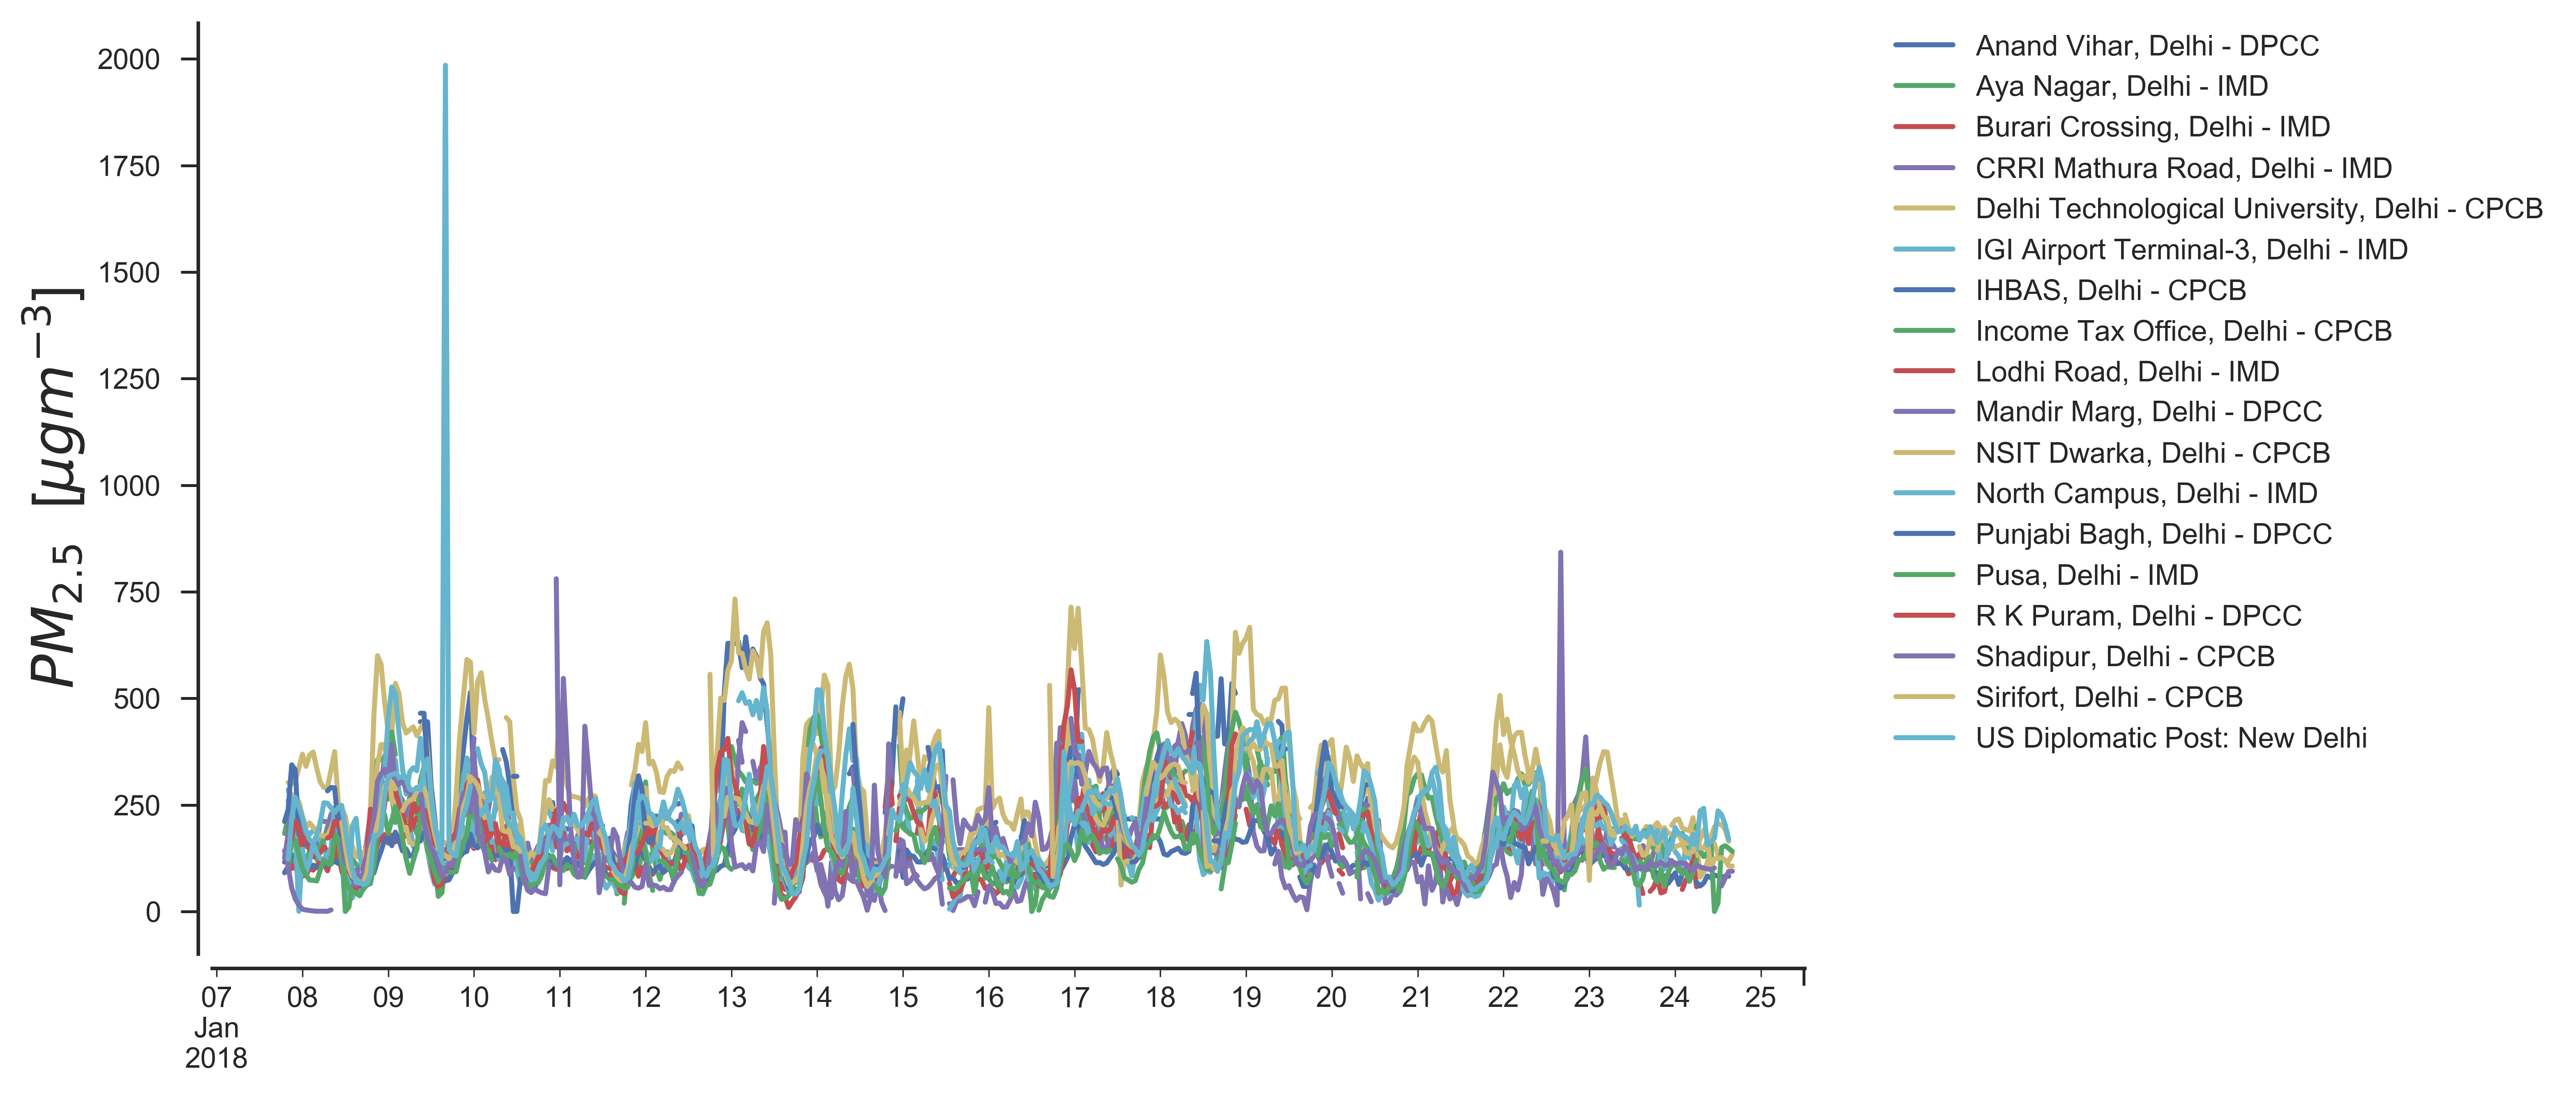

In [38]:
fig, ax = plt.subplots(1, figsize=(10, 6))

for group, df in res.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('1h').mean()
    
    _df.value.plot(ax=ax, label=group)
    
ax.legend(loc='best')
ax.set_ylabel("$PM_{2.5}$  [$\mu g m^{-3}$]", fontsize=20)
ax.set_xlabel("")
sns.despine(offset=5)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

Don't worry too much about how ugly and uninteresting the plot above is...we'll take care of that in the next tutorial! Let's go ahead and look at the distribution of $PM_{2.5}$ values seen in Delhi by various sensors. This is the same data as above, but viewed in a different way.

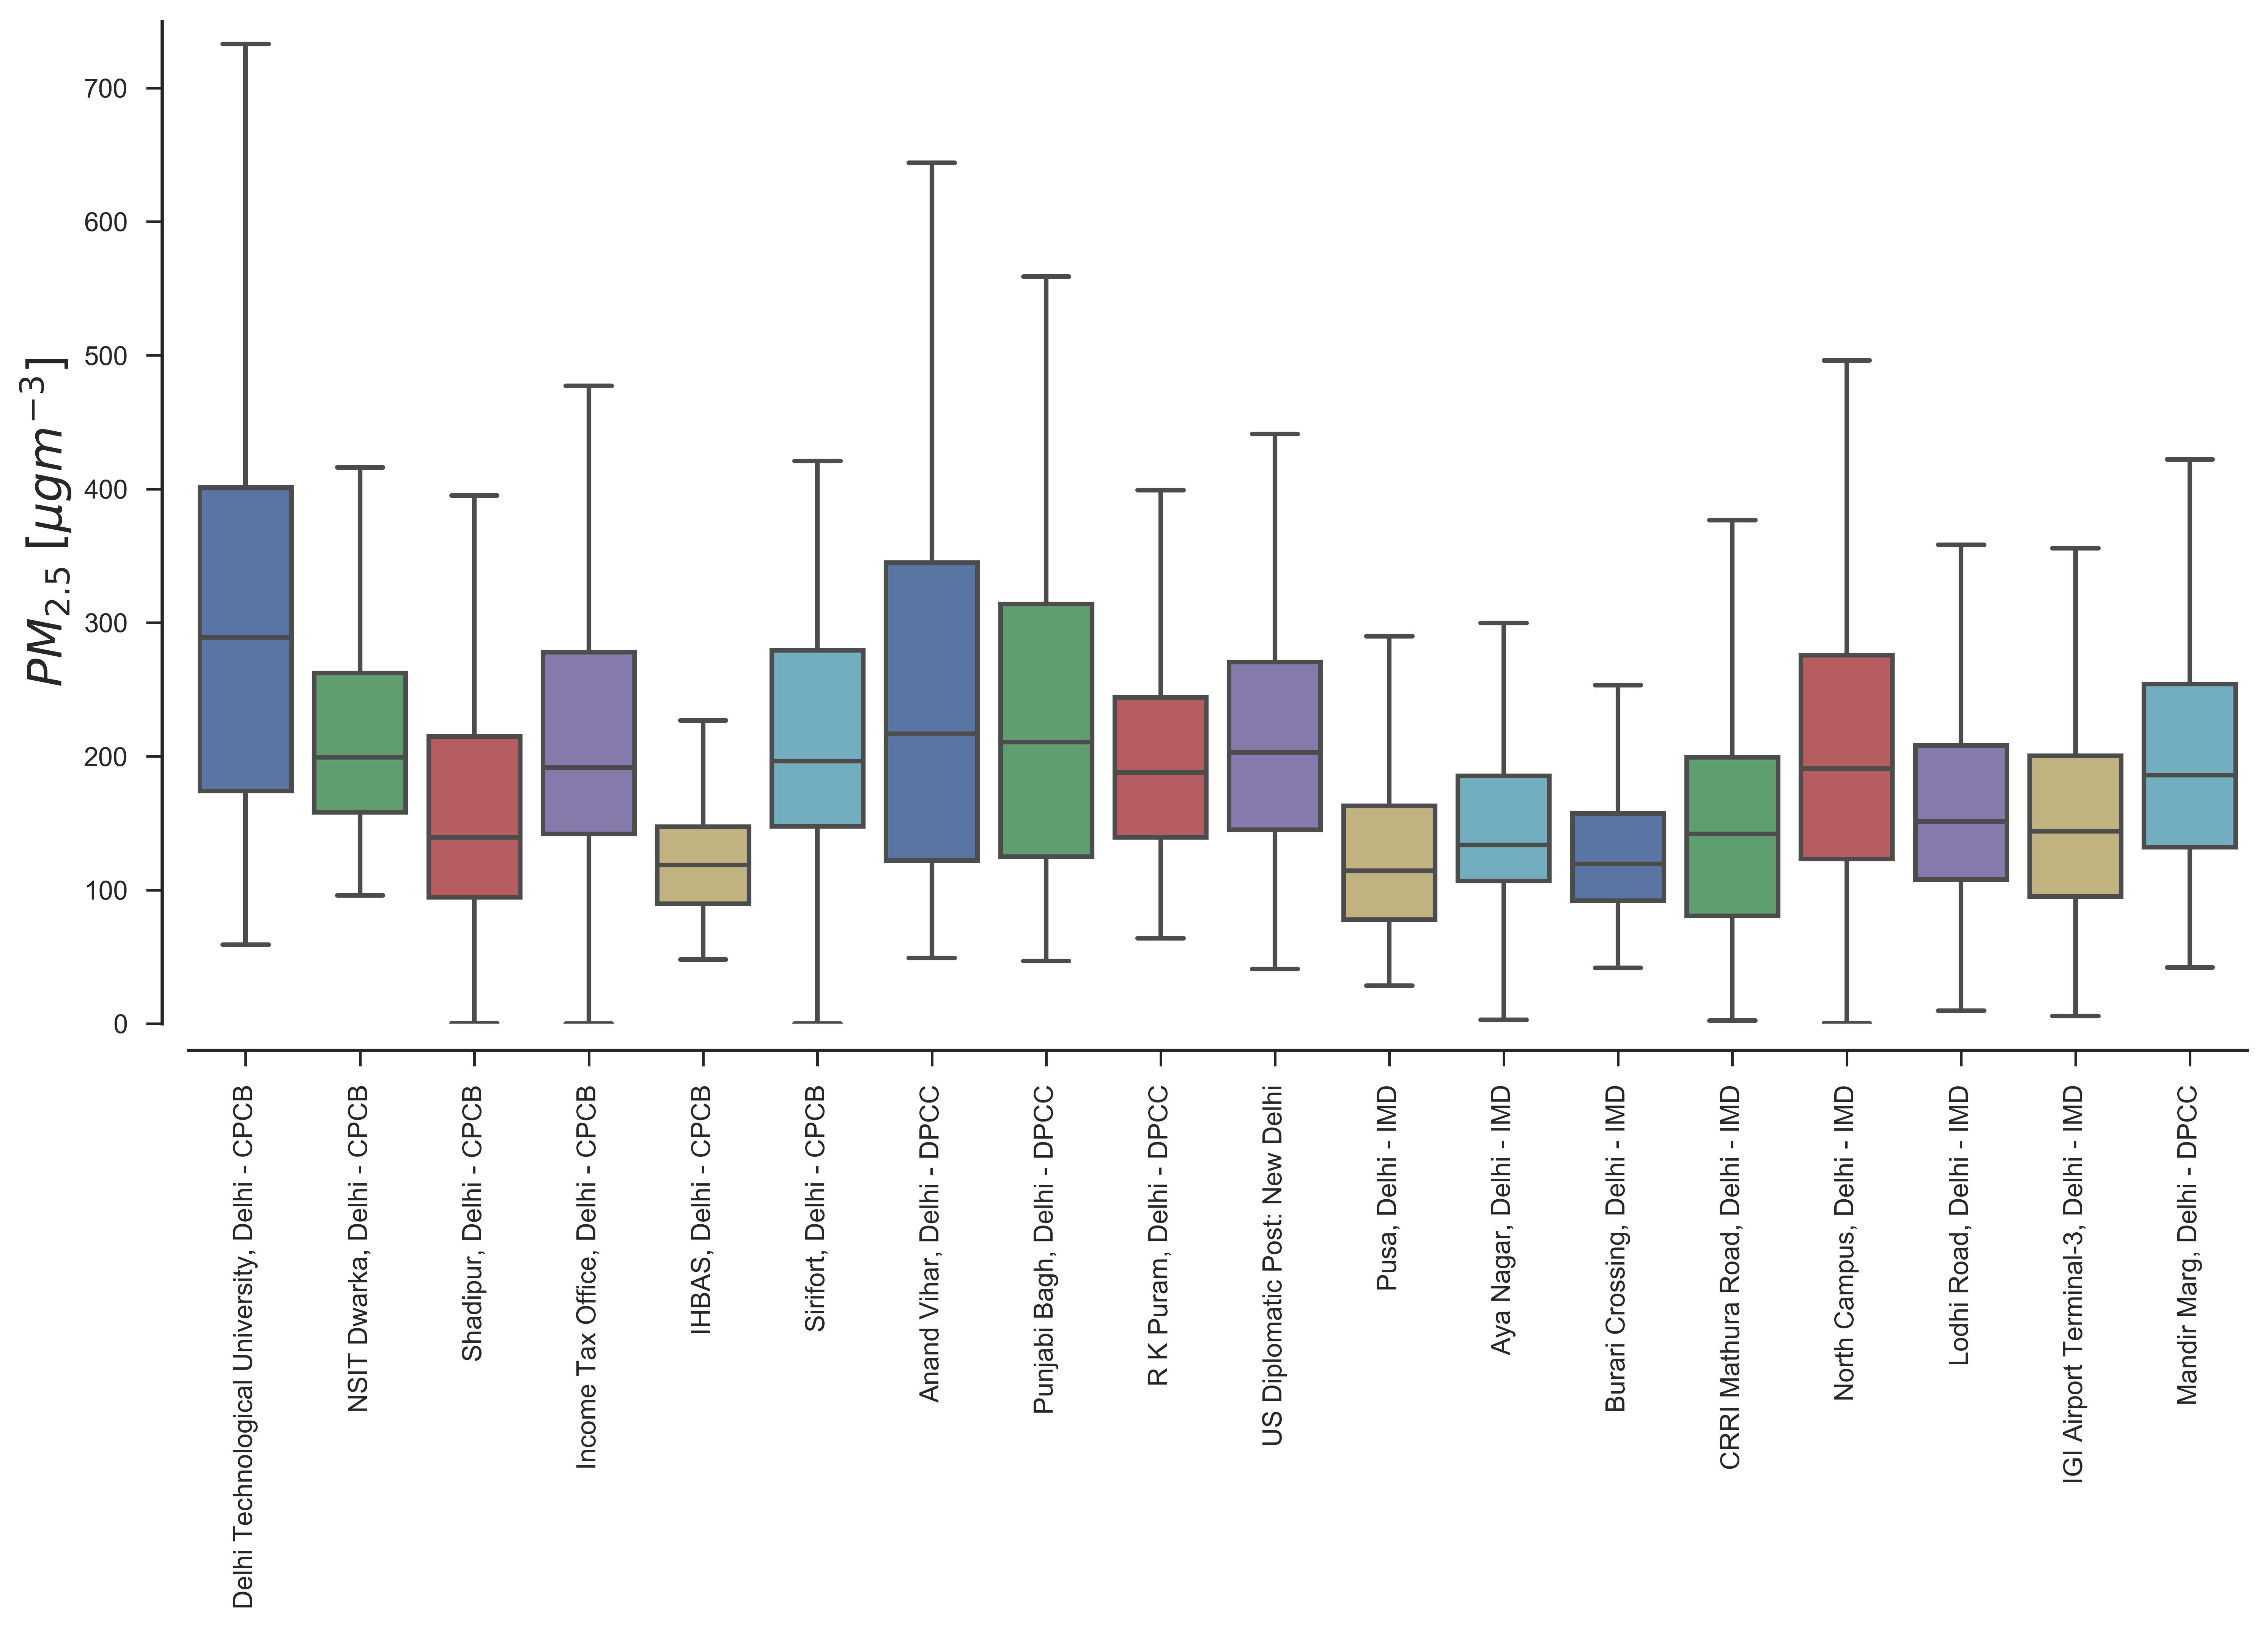

In [37]:
fig, ax = plt.subplots(1, figsize=(14,7))

ax = sns.boxplot(
    x='location', 
    y='value', 
    data=res.query("value >= 0.0"), 
    fliersize=0, 
    palette='deep',
    ax=ax)

ax.set_ylim([0, 750])
ax.set_ylabel("$PM_{2.5}\;[\mu gm^{-3}]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=10)

plt.xticks(rotation=90)
plt.show()

If we remember from above, there was at least one location where many parameters were measured. Let's go ahead and look at that location and see if there is any correlation among parameters!

In [39]:
res = api.measurements(city='Delhi', location='Anand Vihar', limit=1000, df=True)

# Which params do we have?
res.parameter.unique()

array(['o3', 'no2', 'pm10', 'so2', 'pm25'], dtype=object)

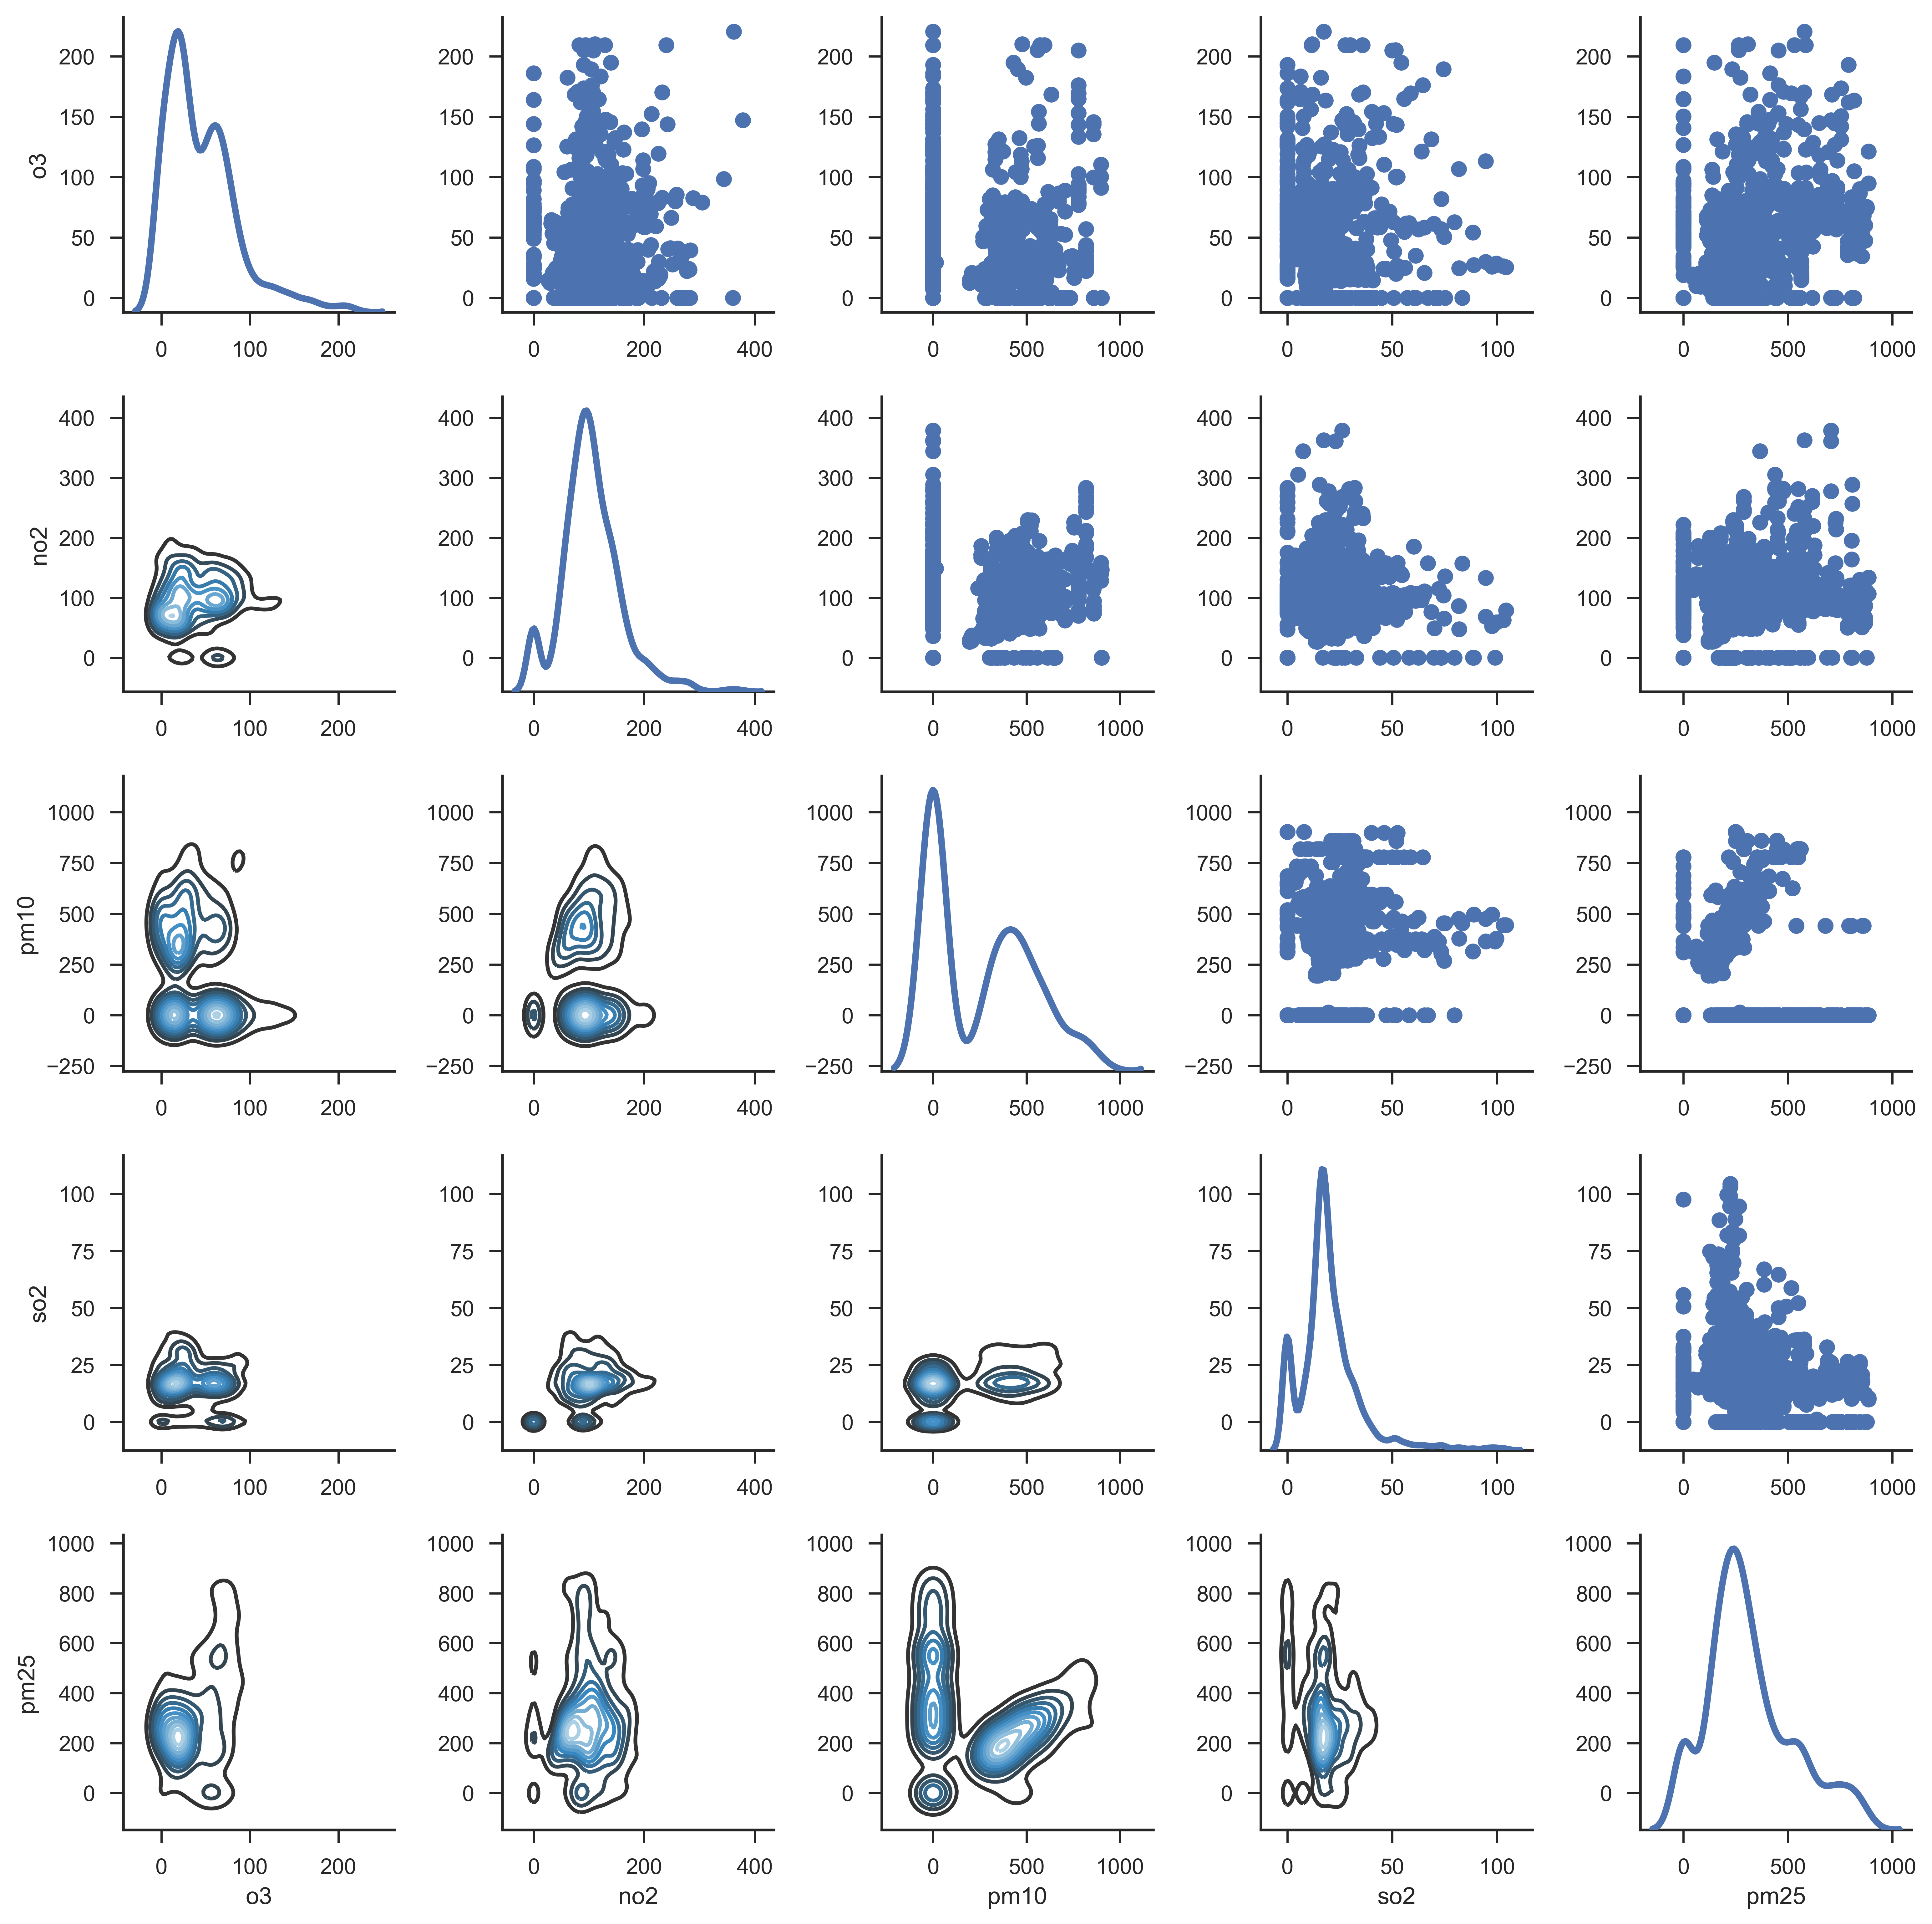

In [40]:
df = pd.DataFrame()

for u in res.parameter.unique():
    _df = res[res['parameter'] == u][['value']]
    _df.columns = [u]
    
    # Merge the dataframes together
    df = pd.merge(df, _df, left_index=True, right_index=True, how='outer')

# Get rid of rows where not all exist
df.dropna(how='any', inplace=True)

g = sns.PairGrid(df, diag_sharey=False)

g.map_lower(sns.kdeplot, cmap='Blues_d')
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

plt.show()

For kicks, let's go ahead and look at a timeseries of $SO_2$ data in Hawai'i. Quiz: What do you expect? Did you know that Hawai'i has a huge $SO_2$ problem?

In [43]:
res = api.measurements(city='Hilo', parameter='so2', limit=10000, df=True)

# Print out the statistics on a per-location basiss
res.groupby(['location'])['value'].describe()

count      mean       std    min    25%    50%    75%  \
location                                                                     
Hawaii Volcanoes NP  355.0  0.007392  0.035338  0.000  0.000  0.000  0.000   
Hilo                 438.0  0.002486  0.004487  0.000  0.001  0.001  0.002   
Kona                 450.0  0.003273  0.004264  0.001  0.001  0.002  0.004   
Ocean View           455.0  0.011490  0.021762  0.000  0.001  0.004  0.011   
Pahala               422.0  0.039166  0.070299  0.000  0.004  0.010  0.040   

                       max  
location                    
Hawaii Volcanoes NP  0.408  
Hilo                 0.050  
Kona                 0.039  
Ocean View           0.182  
Pahala               0.554

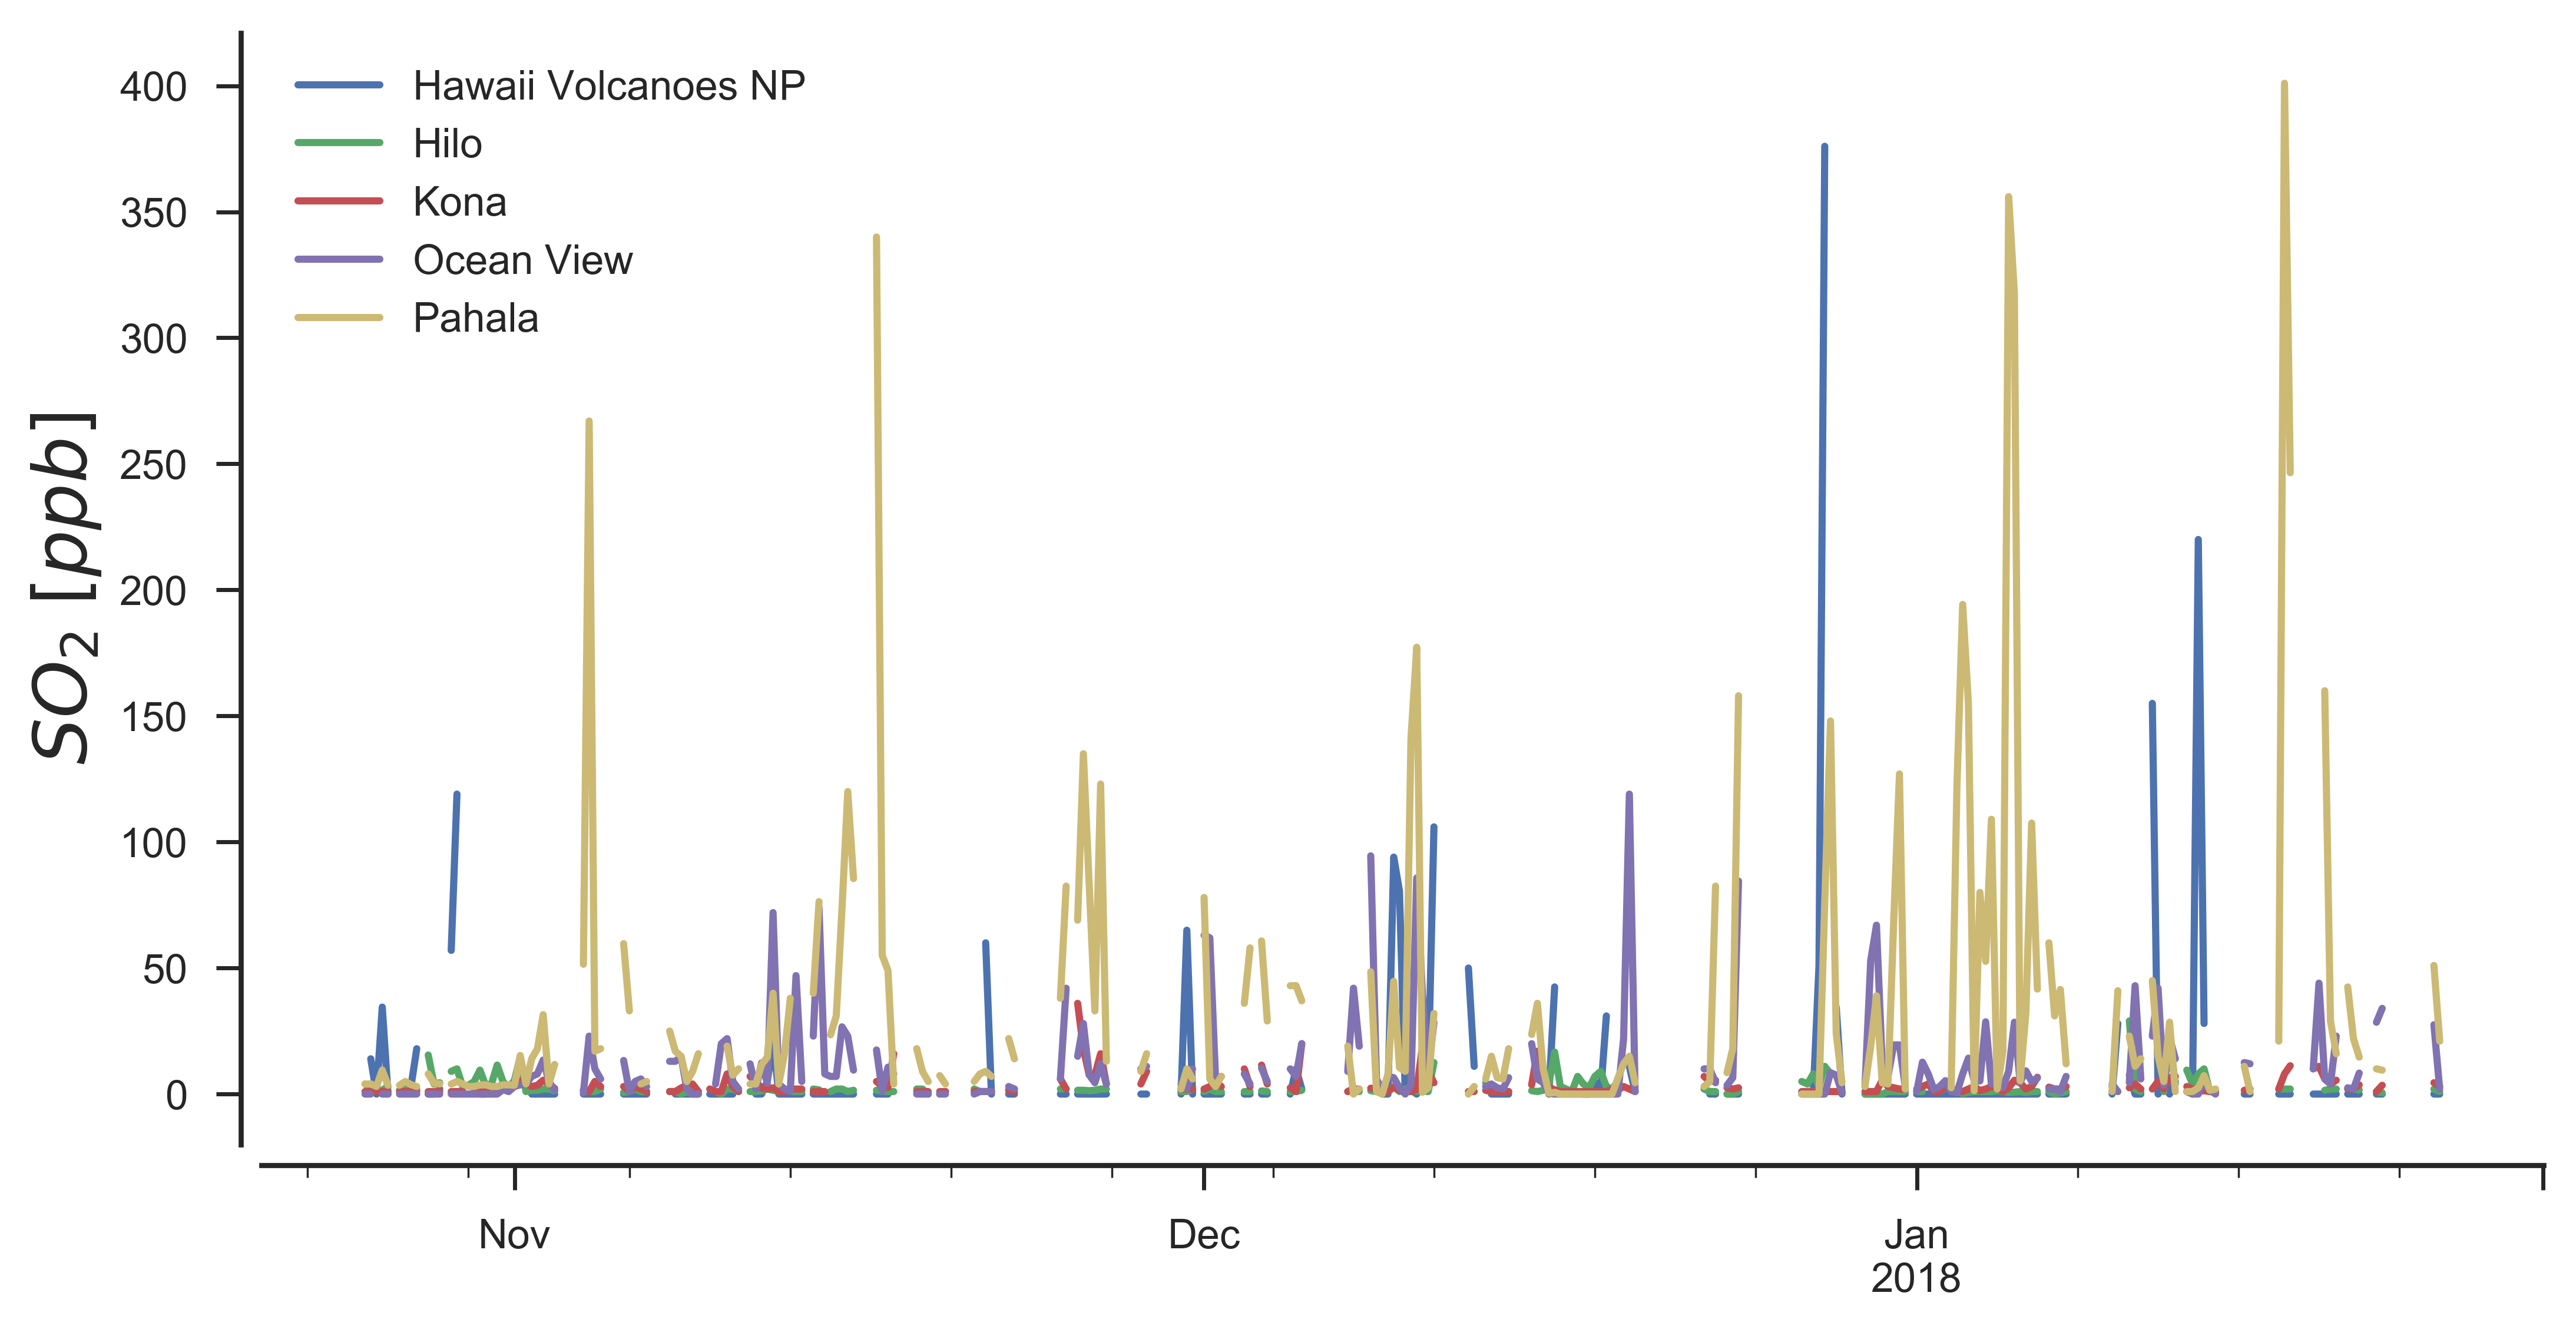

In [45]:
fig, ax = plt.subplots(1, figsize=(10, 5))

for group, df in res.groupby('location'):
    # Query the data to only get positive values and resample to hourly
    _df = df.query("value >= 0.0").resample('6h').mean()
    
    # Convert from ppm to ppb
    _df['value'] *= 1e3
    
    # Multiply the value by 1000 to get from ppm to ppb
    _df.value.plot(ax=ax, label=group)
    
ax.legend(loc='best')
ax.set_ylabel("$SO_2 \; [ppb]$", fontsize=18)
ax.set_xlabel("")

sns.despine(offset=5)

plt.show()

**NOTE:** These values are for 6h means. The local readings can actually get much, much higher (>5 ppm!) when looking at 1min data.